# Recovering Code

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

data_dir = '../data'
mnist = input_data.read_data_sets(data_dir, one_hot=True)

X_train = mnist.train.images
y_train = mnist.train.labels

X_vali = mnist.validation.images
y_vali = mnist.validation.labels

X_test = mnist.test.images
y_test = mnist.test.labels

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


### Building model

In [2]:
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def biases(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pooling(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

W_conv1 = weights([3, 3, 1, 32])
b_conv1 = biases([32])

X_train_reshape = tf.reshape(x, [-1, 28, 28, 1])

h_conv1 = tf.nn.relu(conv2d(X_train_reshape, W_conv1) + b_conv1)
h_pool1 = max_pooling(h_conv1)

W_conv2 = weights([3, 3, 32, 64])
b_conv2 = biases([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pooling(h_conv2)

W_fc1 = weights([7 * 7 * 64, 1024])
b_fc1 = biases([1024])

flatted_feature = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(flatted_feature, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weights([1024, 10])
b_fc2 = biases([10])

y_pred = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y))
opt = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Printing error rates

In [3]:
with tf.Session() as sess:
    tf.train.Saver().restore(sess, '../models/TF_CNN.checkpoint')
    train_error = []
    for i in range(11):
        train_error.append(1-accuracy.eval(feed_dict={x: mnist.train.images[i*5000:(i+1) * 5000], y: mnist.train.labels[i*5000:(i+1) * 5000], keep_prob: 1.0}))
    train_error = np.mean(train_error)
    test_error = 1 - accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})
    print("train error = {:.6f}, test error = {:.6f}".format(train_error, test_error))

INFO:tensorflow:Restoring parameters from ../models/TF_CNN.checkpoint
train error = 0.000000, test error = 0.006500


### Printing confusion Matrix

In [4]:
from sklearn.metrics import confusion_matrix
with tf.Session() as sess:
    tf.train.Saver().restore(sess, '../models/TF_CNN.checkpoint')
    for j in range(11):
        train_pred = np.argmax(y_pred.eval(feed_dict={x: mnist.train.images[j*5000:(j+1) * 5000], y: mnist.train.labels[j*5000:(j+1) * 5000], keep_prob: 1.0}), axis=1)
        train_labels = np.argmax(mnist.train.labels[j*5000:(j+1) * 5000], axis=1)

        if j == 0:
            train_confuse = confusion_matrix(train_labels, train_pred)
        else:
            train_confuse += confusion_matrix(train_labels, train_pred)
    test_pred = np.argmax(y_pred.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0}), axis=1)
    test_labels = np.argmax(mnist.test.labels, axis=1)
    test_confuse = confusion_matrix(test_labels, test_pred)

INFO:tensorflow:Restoring parameters from ../models/TF_CNN.checkpoint


In [5]:
train_confuse

array([[5444,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 6179,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5470,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 5638,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5307,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 4987,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5417,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 5715,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5389,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5454]])

In [6]:
test_confuse

array([[ 979,    0,    0,    0,    0,    0,    0,    1,    0,    0],
       [   0, 1133,    0,    1,    0,    0,    0,    1,    0,    0],
       [   1,    0, 1025,    0,    1,    0,    0,    5,    0,    0],
       [   0,    0,    0, 1005,    0,    2,    0,    0,    3,    0],
       [   0,    0,    0,    0,  976,    0,    2,    0,    0,    4],
       [   1,    0,    0,    3,    0,  886,    1,    1,    0,    0],
       [   4,    2,    0,    1,    1,    1,  948,    0,    1,    0],
       [   0,    1,    3,    1,    0,    0,    0, 1020,    1,    2],
       [   1,    0,    2,    0,    0,    1,    0,    0,  969,    1],
       [   0,    2,    0,    0,    4,    4,    0,    3,    2,  994]])

training confusion matrix
Confusion matrix, without normalization


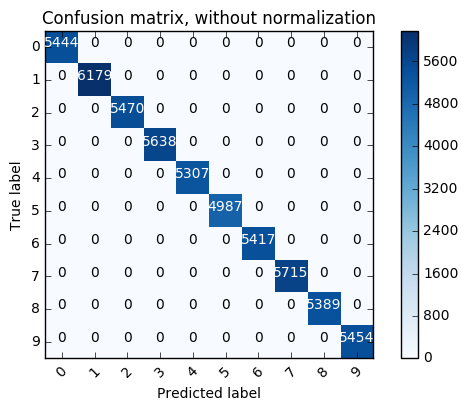

testing confusion matrix
Confusion matrix, without normalization


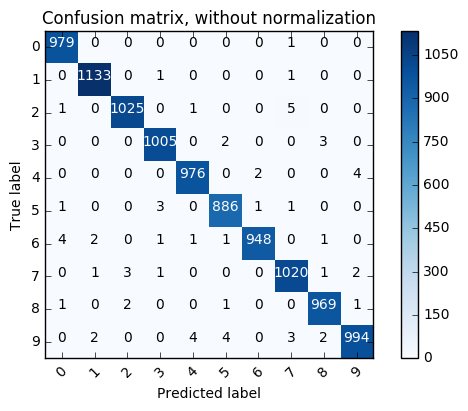

In [7]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
np.set_printoptions(precision=10)
class_names = [str(i) for i in range(10)]
# Plot non-normalized confusion matrix
print("training confusion matrix")
plt.figure()
plot_confusion_matrix(train_confuse, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print("testing confusion matrix")
np.set_printoptions(precision=10)
class_names = [str(i) for i in range(10)]
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(test_confuse, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

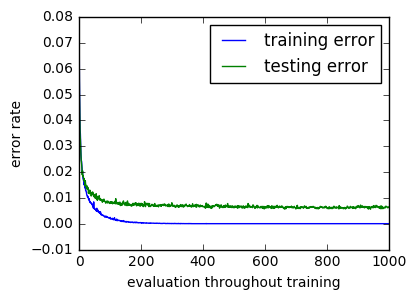

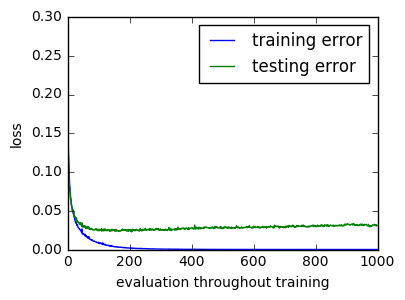

In [8]:
train_error_list = np.load("../models/TF_CNN_train_error_list.npy")
test_error_list = np.load("../models/TF_CNN_test_error_list.npy")
train_loss_list = np.load("../models/TF_CNN_train_loss_list.npy")
test_loss_list = np.load("../models/TF_CNN_test_loss_list.npy")


plt.figure(num=None, figsize=(4, 3), dpi=128, facecolor='w', edgecolor='k')
plt.plot(train_error_list)
plt.plot(test_error_list)
plt.xlabel("evaluation throughout training")
plt.ylabel("error rate")
plt.legend(["training error", "testing error"])
plt.show()


plt.figure(num=None, figsize=(4, 3), dpi=128, facecolor='w', edgecolor='k')
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.xlabel("evaluation throughout training")
plt.ylabel("loss")
plt.legend(["training error", "testing error"])
plt.show()

In [9]:
print("""
\\begin{table}[H]
\t\\centering
\t\\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
\t\t\\hline
\t\ttrain epoch\\textbackslash error & train error & test error \\\\
\t\t\\hline
""")
for i in range(10):
    print("\t\t{} & {:.4f} & {:.4f} \\\\".format(int(len(train_error_list) * i/10), train_error_list[int(len(train_error_list) * i/10)], test_error_list[int(len(train_error_list) * i/10)]))
    print("\t\t\\hline")
print("\t\t{} & {:.4f} & {:.4f} \\\\".format(len(train_error_list)-1, train_error_list[-1], test_error_list[-1]))
print("\t\t\\hline")
print("""
\t\\end{tabular}
\t\\caption{training and testing error}
\t\\label{tab:my_label}
\\end{table}
""")


\begin{table}[H]
	\centering
	\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
		\hline
		train epoch\textbackslash error & train error & test error \\
		\hline

		0 & 0.0789 & 0.0737 \\
		\hline
		100 & 0.0024 & 0.0083 \\
		\hline
		200 & 0.0003 & 0.0079 \\
		\hline
		300 & 0.0001 & 0.0074 \\
		\hline
		400 & -0.0000 & 0.0065 \\
		\hline
		500 & -0.0000 & 0.0063 \\
		\hline
		600 & -0.0000 & 0.0061 \\
		\hline
		700 & -0.0000 & 0.0062 \\
		\hline
		800 & -0.0000 & 0.0059 \\
		\hline
		900 & -0.0000 & 0.0068 \\
		\hline
		999 & -0.0000 & 0.0065 \\
		\hline

	\end{tabular}
	\caption{training and testing error}
	\label{tab:my_label}
\end{table}

